## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# All auxiliary code is in ../src

import sys

sys.path.append("../src/")

# Data understanding

As first thing we imported all necessary modules

In [132]:
import pandas as pd

Then we load our dataset

In [133]:
races = pd.read_csv('../dataset/races.csv')

In [134]:
races.dtypes

_url                    object
name                    object
points                 float64
uci_points             float64
length                 float64
climb_total            float64
profile                float64
startlist_quality        int64
average_temperature    float64
date                    object
position                 int64
cyclist                 object
cyclist_age            float64
is_tarmac                 bool
is_cobbled                bool
is_gravel                 bool
cyclist_team            object
delta                  float64
dtype: object

Diamo una prima occhiata ai valori mancanti nulli

In [135]:
races[races.isnull().any(axis=1)]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589860,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:38,192,anders-lund-1,25.0,True,False,False,watney-avia-1972,80.0
589861,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:40,193,andrea-masciarelli,28.0,True,False,False,NaN,82.0
589862,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:41,194,marco-corti,24.0,True,False,False,kazakhstan-2001,83.0
589863,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:48,195,robbie-mcewen,38.0,True,False,False,radio-popular-paredes-boavista-2023,90.0


Come prima cosa distingurei i valori delle singole corse con i dati relativi ai ciclisti della corsa per cercare di rimuovere ridondanza dei dati che potrebbe falsare le nostre distribuzioni a favore dei valori delle corse con più ciclisti -> separiamo in due tabelle normalizzate

In [136]:
cyclist_races_columns = ['position', 'cyclist', 'cyclist_age', 'cyclist_team', 'delta', 'date']
races_columns = [col for col in races.columns if col not in cyclist_races_columns]
races_data = races.drop_duplicates(subset=races_columns)[races_columns].reset_index(drop=True)

Come si può notare

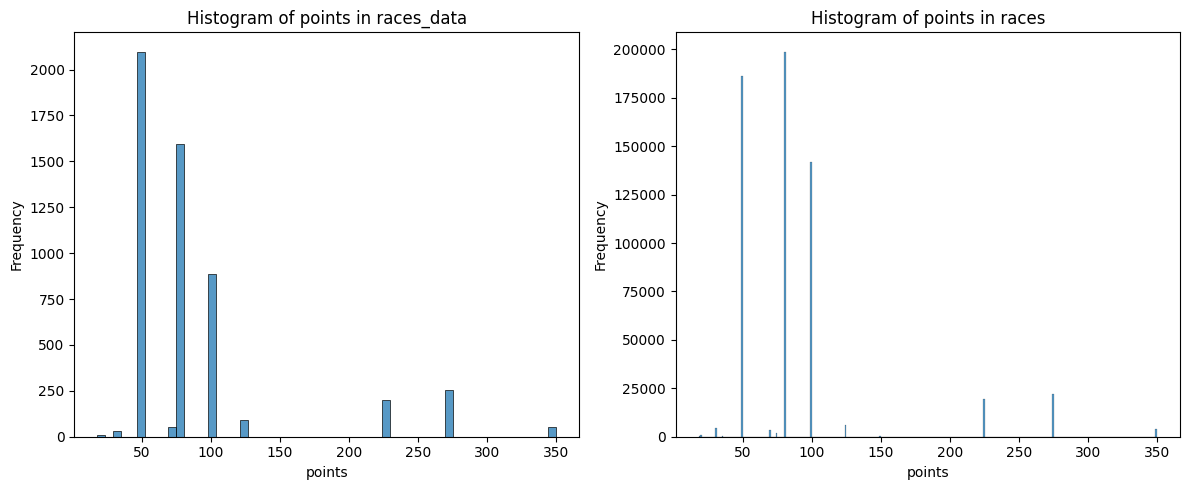

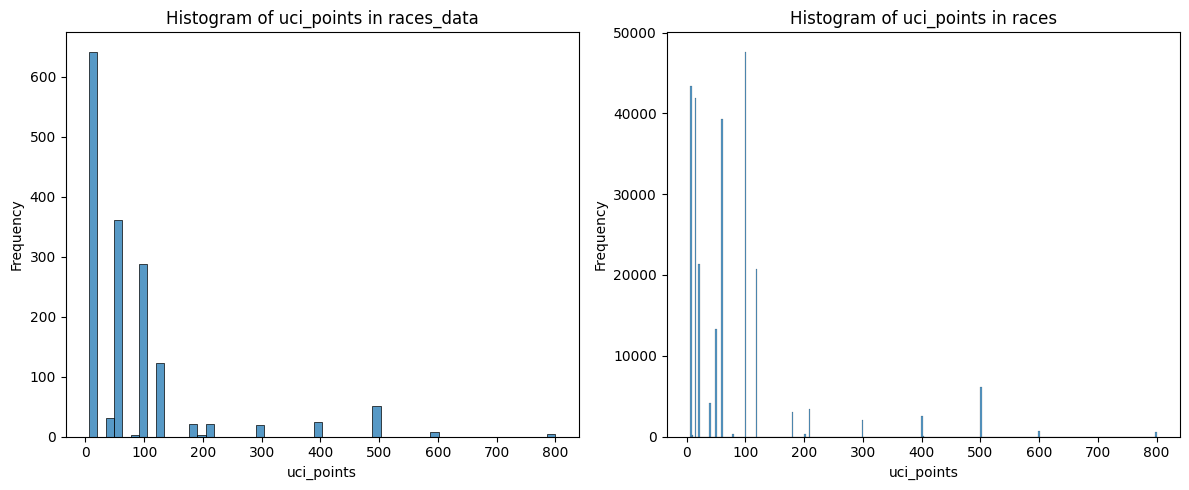

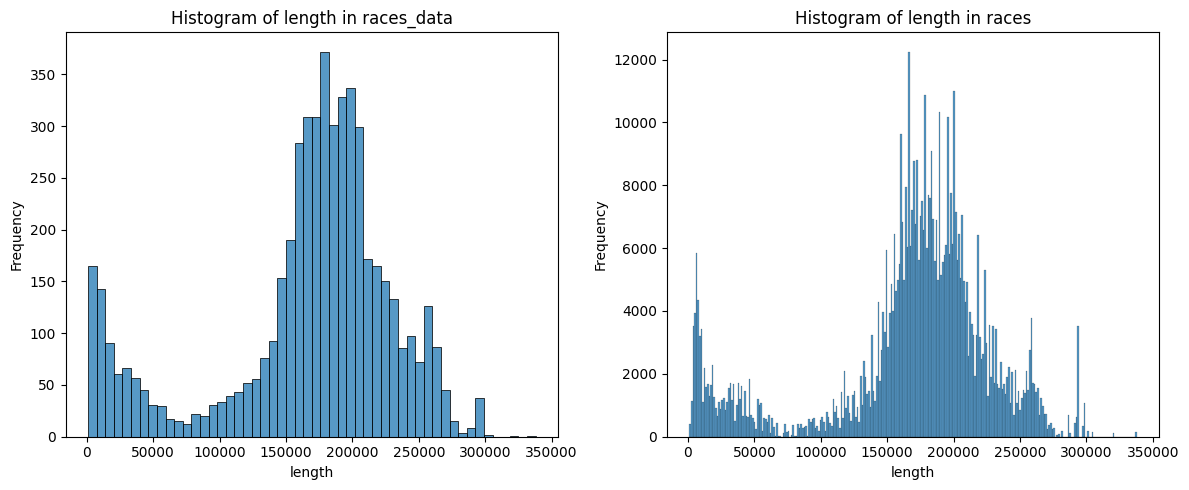

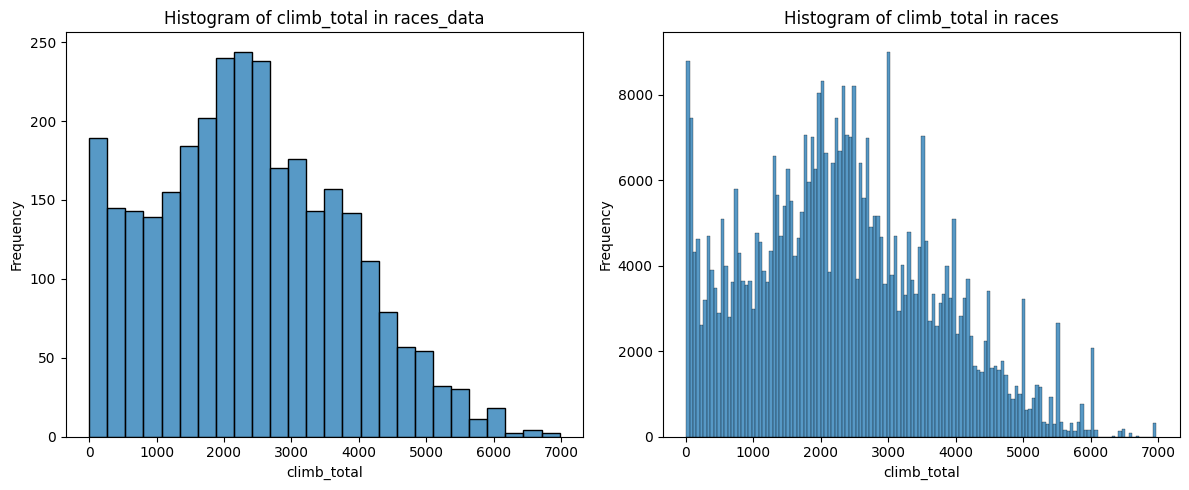

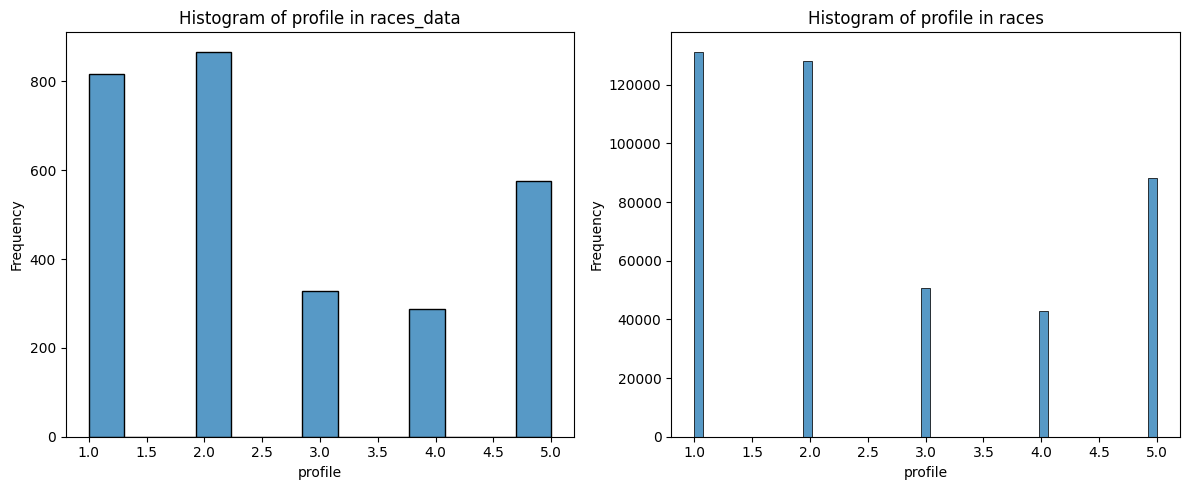

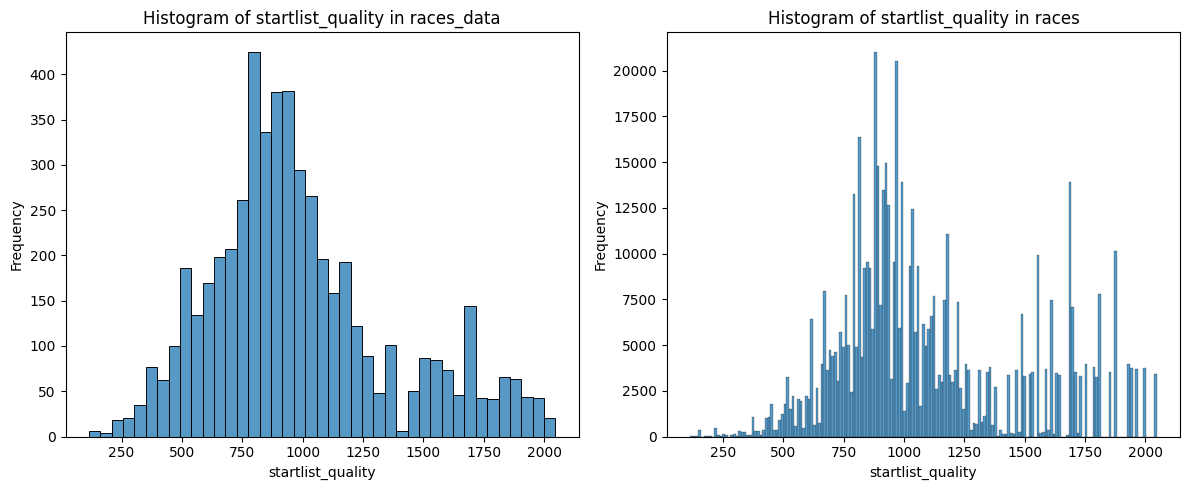

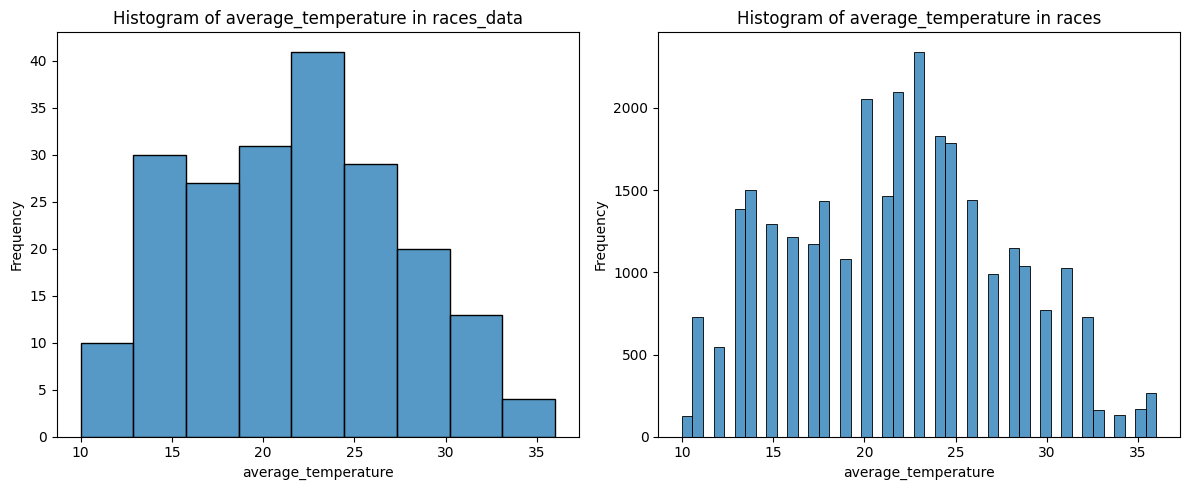

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt


for feature in races_data.select_dtypes(include="number").columns: 
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Istogramma per races_data
    sns.histplot(races_data[feature], ax=axes[0])
    axes[0].set_title(f'Histogram of {feature} in races_data')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Frequency')

    # Istogramma per races
    sns.histplot(races[feature], ax=axes[1])
    axes[1].set_title(f'Histogram of {feature} in races')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

# Stats on attributes

In [138]:
from matplotlib import pyplot as plt
import numpy as np

def stats(column, box=True):
    print(f"Description of attribute '{column.name}':")
    display(column.describe())
    print("\nUnique values:")
    print(column.unique())
    print(f"\nNumber of null values: {column.isnull().sum()}")
    print("\nTop 5 common value:" + "\n"+str(column.value_counts().head()))
    # conteggi_valori = column.value_counts(dropna=True)

    # # Prendi il valore top (più frequente)
    # top = conteggi_valori.idxmax()

    # # Stampa il valore top
    # print("\nTop value: ", top)
    
    if box:
        boxplot_dict = plt.boxplot(column[~np.isnan(column)])
        # Recover Outliers
        outliers = [flier.get_ydata() for flier in boxplot_dict['fliers']]
        # Print outliers
        outliers_values = [value for sublist in outliers for value in sublist]
        print("\nOutliers:", outliers_values)

Age

Ci accorgiamo che il 13-enne è un errore perchè le gare ammettono maggiorenni. Il 56-enne è un outliers. Controllare i valori al di fuori della coda del boxplot

Description of attribute 'cyclist_age':


count    589752.000000
mean         28.486208
std           3.855631
min          13.000000
25%          26.000000
50%          28.000000
75%          31.000000
max          56.000000
Name: cyclist_age, dtype: float64


Unique values:
[22. 27. 24. 30. 26. 36. 23. 32. 31. 28. 29. 21. 25. 35. 38. 39. 34. 37.
 33. 40. 20. 19. nan 42. 41. 44. 43. 45. 56. 13.]

Number of null values: 113

Top 5 common value:
cyclist_age
27.0    58897
26.0    57921
28.0    56213
25.0    54346
29.0    52616
Name: count, dtype: int64

Outliers: [np.float64(13.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(40.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(40.0), np.float64(40.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(42.0), np.float64(41.0), np.float64(39.0), np.float64(40.0), np.float64(42.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(39.0), np.float64(40.0), np.float64(39.0), np.float64(39.0), np.float64(40.0), np.float64(39.0), np.float64(39.0), np.float64(42.0), np.float

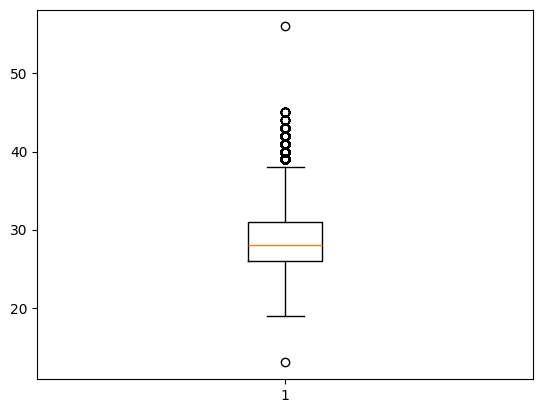

In [139]:
stats(races["cyclist_age"], box=True)

Url

In [140]:
stats(races["_url"])

Description of attribute '_url':


count                          589865
unique                           5281
top       tour-de-france/1986/stage-1
freq                              210
Name: _url, dtype: object


Unique values:
['tour-de-france/1978/stage-6' 'vuelta-a-espana/2016/stage-14'
 'tour-de-france/2019/stage-21' ... 'paris-nice/1976/stage-2'
 'volta-a-catalunya/2016/stage-7' 'giro-d-italia/2010/stage-1']

Number of null values: 0

Top 5 common value:
_url
tour-de-france/1986/stage-1     210
tour-de-france/1986/prologue    210
tour-de-france/1987/prologue    207
giro-d-italia/2011/stage-2      206
tour-de-france/1987/stage-1     206
Name: count, dtype: int64


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Name

In [128]:
stats(races["name"])

Description of attribute 'name':


count             589865
unique                61
top       Tour de France
freq              145500
Name: name, dtype: object


Unique values:
['Tour de France' 'Vuelta a España' 'Volta Ciclista a Catalunya'
 'Paris - Nice' 'Tirreno-Adriatico' 'Critérium du Dauphiné Libéré'
 'Critérium du Dauphiné' 'Ronde van Vlaanderen / Tour des Flandres'
 'Milano-Sanremo' 'Tour de Suisse' "Giro d'Italia" 'Gran Camiño'
 'Tour de Romandie' 'Volta a Catalunya' 'La Vuelta ciclista a España'
 'La Flèche Wallonne' 'E3-Prijs Harelbeke' 'Vuelta al País Vasco'
 'Vuelta Ciclista al País Vasco' 'Liège - Bastogne - Liège'
 'Paris-Roubaix' 'UAE Tour' 'World Championships ME - Road Race'
 'Amstel Gold Race' 'Dwars door België / À travers la Belgique'
 'Itzulia Basque Country' 'World Championships - Road Race'
 'Criterium du Dauphiné Libére' 'Omloop Het Volk'
 'Clasica Ciclista San Sebastian' 'Paris - Roubaix' 'Strade Bianche'
 'Giro di Lombardia' 'Criterium du Dauphiné' 'O Gran Camiño'
 'Grand Prix Cycliste de Quebec' 'Grand Prix Cycliste de Montréal'
 'Ronde van Vlaanderen - Tour des Flandres ME'
 'Dwars door Vlaanderen - A travers la F

Description of attribute 'points':


count    589388.000000
mean         89.221635
std          54.435330
min          18.000000
25%          50.000000
50%          80.000000
75%         100.000000
max         350.000000
Name: points, dtype: float64


Unique values:
[100.  80.  50. 275.  20. 225. 125. 350.  75.  70.  30. 150.  35.  nan
  18.]

Number of null values: 477

Top 5 common value:
points
80.0     198878
50.0     186102
100.0    141706
275.0     22299
225.0     19536
Name: count, dtype: int64


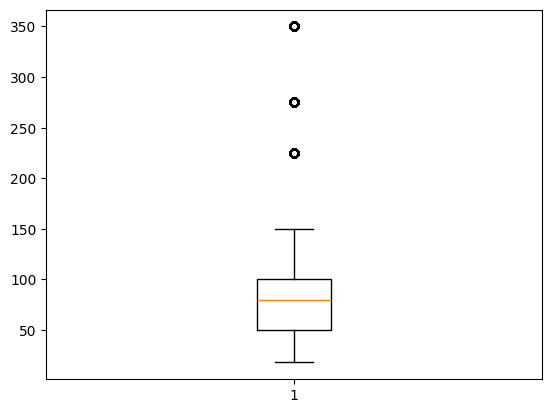

In [103]:
stats(races["points"], box=True)

Description of attribute 'uci_points':


count    251086.000000
mean         74.601547
std         100.947962
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64


Unique values:
[ nan 100. 120.  50.  60.   6.  14.  16. 500.  20.  40. 210. 400. 300.
 800. 180. 200. 600.  80.  10. 402.]

Number of null values: 338779

Top 5 common value:
uci_points
100.0    47640
6.0      43390
16.0     41103
60.0     39317
20.0     21303
Name: count, dtype: int64


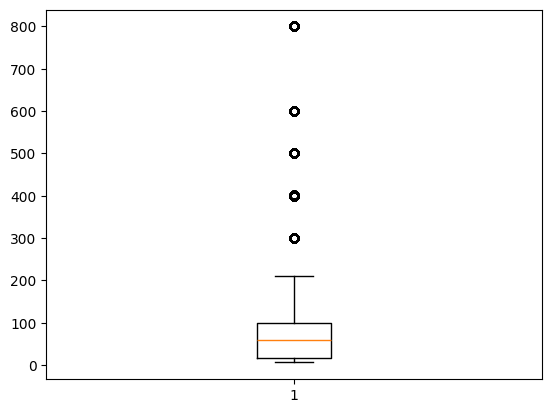

In [104]:
stats(races["uci_points"], box=True)

Description of attribute 'length':


count    589865.000000
mean     166776.180584
std       64545.605664
min        1000.000000
25%      152500.000000
50%      178200.000000
75%      203500.000000
max      338000.000000
Name: length, dtype: float64


Unique values:
[162000. 196000. 128000. ... 301000. 184200. 136400.]

Number of null values: 0

Top 5 common value:
length
177000.0    5039
170000.0    4717
195000.0    4413
200000.0    4401
178000.0    4286
Name: count, dtype: int64


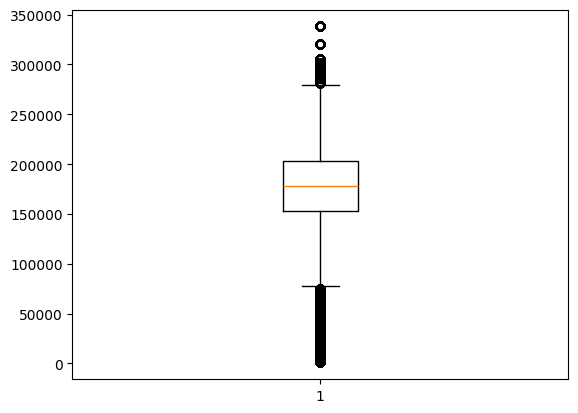

In [105]:
stats(races["length"], box=True)

Description of attribute 'climb_total':


count    442820.000000
mean       2330.469215
std        1375.710722
min           2.000000
25%        1309.000000
50%        2255.000000
75%        3273.000000
max        6974.000000
Name: climb_total, dtype: float64


Unique values:
[1101. 5575.  781. ...  713. 1441.   60.]

Number of null values: 147045

Top 5 common value:
climb_total
3500.0    3762
2500.0    3261
4000.0    3029
3000.0    2938
5000.0    2592
Name: count, dtype: int64


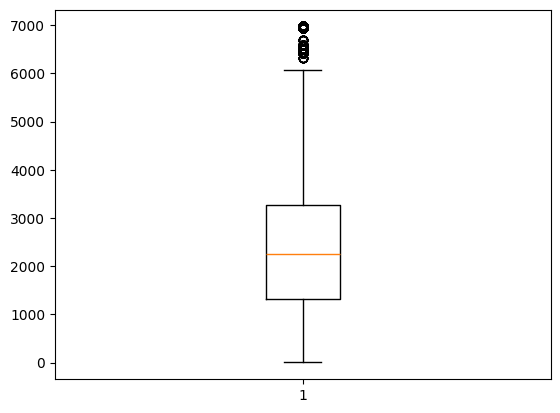

In [106]:
stats(races["climb_total"], box=True)

Description of attribute 'uci_points':


count    251086.000000
mean         74.601547
std         100.947962
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64


Unique values:
[ nan 100. 120.  50.  60.   6.  14.  16. 500.  20.  40. 210. 400. 300.
 800. 180. 200. 600.  80.  10. 402.]

Number of null values: 338779

Top 5 common value:
uci_points
100.0    47640
6.0      43390
16.0     41103
60.0     39317
20.0     21303
Name: count, dtype: int64


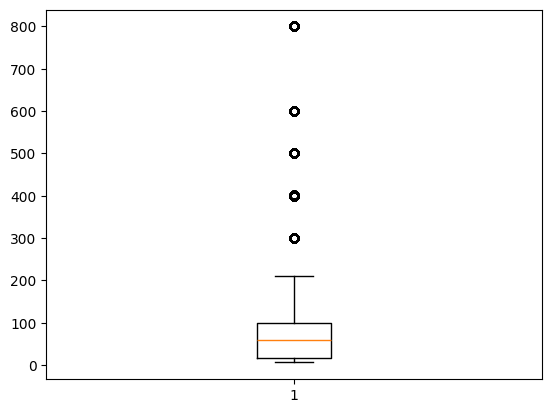

In [107]:
stats(races["uci_points"], box=True)

Description of attribute 'profile':


count    441671.000000
mean          2.611611
std           1.491741
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: profile, dtype: float64


Unique values:
[ 1.  5. nan  3.  2.  4.]

Number of null values: 148194

Top 5 common value:
profile
1.0    131344
2.0    128269
5.0     88203
3.0     50844
4.0     43011
Name: count, dtype: int64


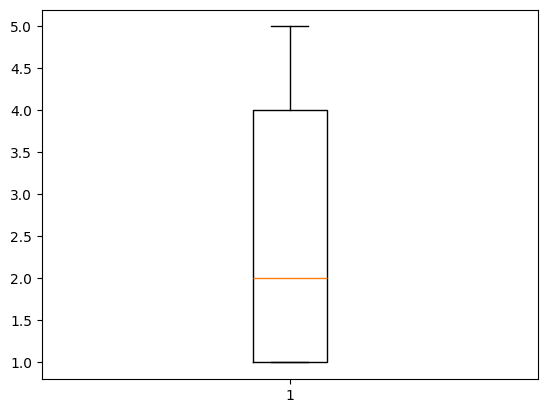

In [108]:
stats(races["profile"], box=True) # ? occhio a media su categorico

Description of attribute 'startlist_quality':


count    589865.000000
mean       1101.161178
std         380.586928
min         115.000000
25%         844.000000
50%         988.000000
75%        1309.000000
max        2047.000000
Name: startlist_quality, dtype: float64


Unique values:
[1241  821 1699  804 1551  899  659  388  900  541  830  789  602  817
 1400 1161 1040  896  791  819  670  225  520 1057  809  828  722  747
  714  815  376  621  760  798  933 1994 1437 1362  884 1150  971  881
 1112 1175  891  878  400  936  692  727 1002  928 1196 1489  687  585
  835  673 1328  885  502  861  982  923 1036 1690  925  989 1109 1084
  803  792  548  668 1713 1520 1959  883  859 2047 1024  533 1269  751
 1202  570 1703 1416  251 1158 1139  657 1048  521 1034 1099  880 1029
  627  340  767  737 1220  824  369 1255 1019  995 1059 1342  968  676
 1381  705  680  779 1123 1020 1632 1251 1470  708  892  523  590  604
  781  614 1309  951 1812  877 1758  843 1041 1646  935  660  961 1238
 1496  765  494 1933  956 1849 1136  393  882  597  874  908  888  530
 1089  446  838  373 1872  638  794  932 1331  377  719 1121 1042 1165
 1105 1535 1492  732  866  920  917 1584  653  906  551  611  772  852
  607 1177  389  873  966  775  790 1090  302  478  952 1176 

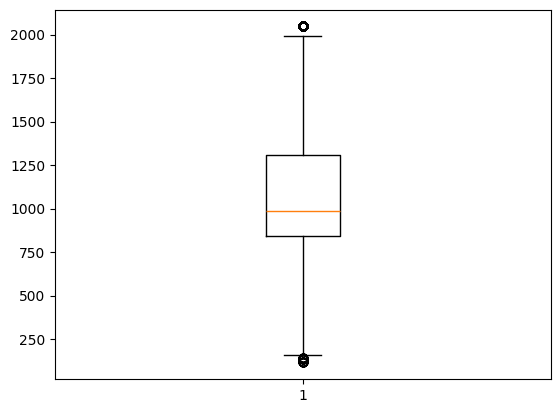

In [109]:
stats(races["startlist_quality"], box=True)

Description of attribute 'average_temperature':


count    29933.000000
mean        21.731768
std          5.884761
min         10.000000
25%         17.000000
50%         22.000000
75%         26.000000
max         36.000000
Name: average_temperature, dtype: float64


Unique values:
[nan 24. 22. 13. 10. 19. 29. 20. 11. 25. 15. 23. 31. 21. 27. 32. 16. 14.
 26. 30. 28. 18. 17. 34. 12. 35. 36. 33.]

Number of null values: 559932

Top 5 common value:
average_temperature
23.0    2343
22.0    2099
20.0    2055
24.0    1829
25.0    1789
Name: count, dtype: int64


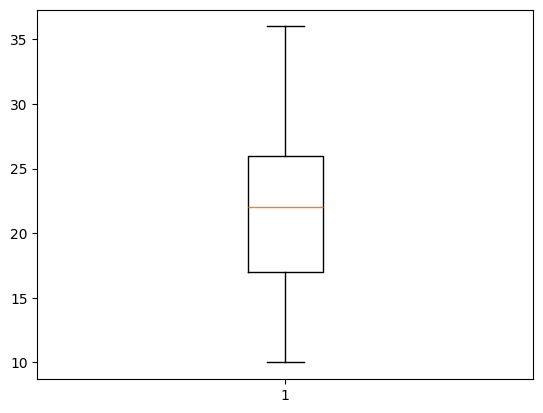

In [110]:
stats(races["average_temperature"], box=True)

In [111]:
stats(races["date"])

Description of attribute 'date':


count                  589865
unique                 140509
top       1986-07-05 01:58:44
freq                      203
Name: date, dtype: object


Unique values:
['1978-07-05 04:02:24' '1978-07-05 04:02:51' '1978-07-05 04:03:28' ...
 '2010-05-08 00:11:41' '2010-05-08 00:11:48' '2010-05-08 00:11:49']

Number of null values: 0

Top 5 common value:
date
1986-07-05 01:58:44    203
1987-07-05 01:50:51    200
2013-06-29 04:56:52    198
1988-07-05 04:52:08    197
1987-07-02 02:11:56    195
Name: count, dtype: int64


In [112]:
stats(races["position"]) # ordinale numerico come gestirlo?

Description of attribute 'position':


count    589865.000000
mean         74.219491
std          48.404023
min           0.000000
25%          32.000000
50%          70.000000
75%         112.000000
max         209.000000
Name: position, dtype: float64


Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]

Number of null values: 0

Top 5 common value:
position
0    5281
1    5275
2    5273
3    5267
4    5255
Name: count, dtype: int64

In [113]:
stats(races["cyclist"])

Description of attribute 'cyclist':


count             589865
unique              6095
top       matteo-tosatto
freq                 959
Name: cyclist, dtype: object


Unique values:
['sean-kelly' 'gerrie-knetemann' 'rene-bittinger' ... 'jon-ander-insausti'
 'carlos-melero' 'roland-smet']

Number of null values: 0

Top 5 common value:
cyclist
matteo-tosatto        959
alejandro-valverde    942
luis-leon-sanchez     899
imanol-erviti         883
haimar-zubeldia       883
Name: count, dtype: int64


Description of attribute 'cyclist_age':


count    589752.000000
mean         28.486208
std           3.855631
min          13.000000
25%          26.000000
50%          28.000000
75%          31.000000
max          56.000000
Name: cyclist_age, dtype: float64


Unique values:
[22. 27. 24. 30. 26. 36. 23. 32. 31. 28. 29. 21. 25. 35. 38. 39. 34. 37.
 33. 40. 20. 19. nan 42. 41. 44. 43. 45. 56. 13.]

Number of null values: 113

Top 5 common value:
cyclist_age
27.0    58897
26.0    57921
28.0    56213
25.0    54346
29.0    52616
Name: count, dtype: int64


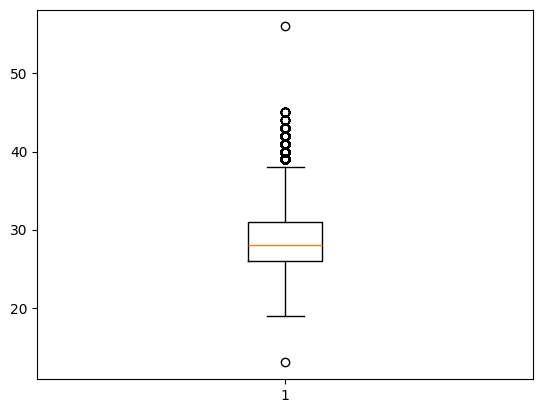

In [114]:
stats(races["cyclist_age"], box=True)

In [115]:
stats(races["is_tarmac"])

Description of attribute 'is_tarmac':


count     589865
unique         2
top         True
freq      536042
Name: is_tarmac, dtype: object


Unique values:
[ True False]

Number of null values: 0

Top 5 common value:
is_tarmac
True     536042
False     53823
Name: count, dtype: int64


In [116]:
stats(races["is_cobbled"])

Description of attribute 'is_cobbled':


count     589865
unique         1
top        False
freq      589865
Name: is_cobbled, dtype: object


Unique values:
[False]

Number of null values: 0

Top 5 common value:
is_cobbled
False    589865
Name: count, dtype: int64


In [117]:
stats(races["is_gravel"])

Description of attribute 'is_gravel':


count     589865
unique         1
top        False
freq      589865
Name: is_gravel, dtype: object


Unique values:
[False]

Number of null values: 0

Top 5 common value:
is_gravel
False    589865
Name: count, dtype: int64


In [118]:
stats(races["cyclist_team"])

Description of attribute 'cyclist_team':


count                              430704
unique                                 91
top       liberty-seguros-wurth-team-2005
freq                                 8869
Name: cyclist_team, dtype: object


Unique values:
['vini-ricordi-pinarello-sidermec-1986' 'norway-1987' nan
 'navigare-blue-storm-1993' 'spain-1991' 'kelme-costa-blanca-2000'
 'japan-2008' 'ville-de-charleroi-new-systems-2000' 'switzerland-1997'
 'germany-2004' 'hungary-2002' 'radio-popular-paredes-boavista-2023'
 'new-zealand-1991' 'canada-1996' 'linea-md-italia-maggi-mobili-1985'
 'kazakhstan-2019' 'kondor-1979' 'mexico-1986' 'spar-rdm-1999'
 'o.n.c.e.-deutsche-bank-2000' 'rally-cycling-2021'
 'euskaltel-euskadi-2010' 'ceramica-panaria-navigare-2007'
 'united-states-1998' 'carlos-cycles-1975' 'ireland-2005'
 'team-saxo-bank-tinkoff-bank-2012' 'south-africa-1993'
 'liberty-seguros-wurth-team-2005' 'del-tongo-1986'
 'team-giant-shimano-2014' 'bora-hansgrohe-2021' 'france-1978'
 'australia-1991' 'teka-1988' 'cantanhede-marques-de-marialva-2003'
 'jolly-ceramica-1977' 'canada-2020' 'netherlands-1974' 'atala-1985'
 'czechoslovakia-1987' 'carrera-inoxpran-1985' 'luxembourg-2013'
 'denmark-1991' 'euskaltel-euskadi-2012' 'co

Description of attribute 'delta':


count    589865.000000
mean        418.292794
std         842.961596
min       -6906.000000
25%          10.000000
50%         156.000000
75%         624.000000
max       61547.000000
Name: delta, dtype: float64


Unique values:
[0.0000e+00 2.7000e+01 6.4000e+01 ... 2.4264e+04 3.4523e+04 3.4522e+04]

Number of null values: 0

Top 5 common value:
delta
0.0    120546
2.0      3700
5.0      3353
3.0      3178
4.0      3036
Name: count, dtype: int64


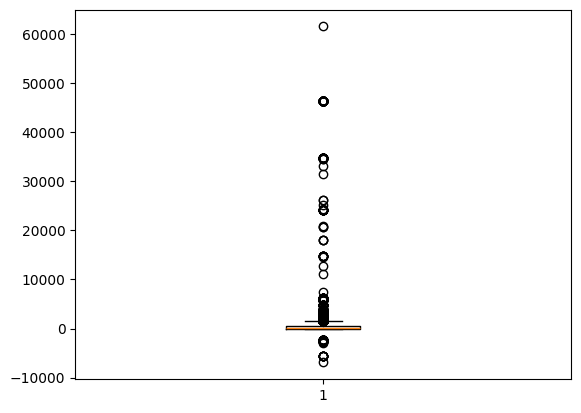

In [119]:
stats(races["delta"], box=True)

In [127]:
races[races["_url"].str.startswith('vuelta-a-espana/1996/stage')]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
39150,vuelta-a-espana/1996/stage-14,Vuelta a España,80.0,NaN,202600.0,3067.0,NaN,988,NaN,1996-09-21 04:48:14,0,biagio-conte,28.0,True,False,False,NaN,0.0
39151,vuelta-a-espana/1996/stage-14,Vuelta a España,80.0,NaN,202600.0,3067.0,NaN,988,NaN,1996-09-21 04:48:14,1,orlando-sergio-rodrigues,27.0,True,False,False,NaN,0.0
39152,vuelta-a-espana/1996/stage-14,Vuelta a España,80.0,NaN,202600.0,3067.0,NaN,988,NaN,1996-09-21 04:50:11,2,laurent-dufaux,27.0,True,False,False,bankgiroloterij-batavus-2000,117.0
39153,vuelta-a-espana/1996/stage-14,Vuelta a España,80.0,NaN,202600.0,3067.0,NaN,988,NaN,1996-09-21 04:50:11,3,laurent-jalabert,28.0,True,False,False,team-volksbank-2008,117.0
39154,vuelta-a-espana/1996/stage-14,Vuelta a España,80.0,NaN,202600.0,3067.0,NaN,988,NaN,1996-09-21 04:50:11,4,alex-zulle,28.0,True,False,False,team-volksbank-2008,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507949,vuelta-a-espana/1996/stage-13,Vuelta a España,80.0,NaN,159000.0,3051.0,NaN,988,NaN,1996-09-20 04:24:29,137,lorenzo-di-silvestro,26.0,True,False,False,NaN,1361.0
507950,vuelta-a-espana/1996/stage-13,Vuelta a España,80.0,NaN,159000.0,3051.0,NaN,988,NaN,1996-09-20 04:25:04,138,marco-antonio-di-renzo,27.0,True,False,False,NaN,1396.0
507951,vuelta-a-espana/1996/stage-13,Vuelta a España,80.0,NaN,159000.0,3051.0,NaN,988,NaN,1996-09-20 04:25:04,139,juri-recanati,26.0,True,False,False,NaN,1396.0
507952,vuelta-a-espana/1996/stage-13,Vuelta a España,80.0,NaN,159000.0,3051.0,NaN,988,NaN,1996-09-20 04:26:03,140,hendrik-redant,34.0,True,False,False,norway-1987,1455.0


# Data quality

## Age

## Name

Alcuni nomi di gare differiscono per alcuni caratteri

In [141]:
unique_names=races['name'].unique()
sorted(unique_names)

['Amstel Gold Race',
 'Clasica Ciclista San Sebastian',
 'Clásica Ciclista San Sebastian',
 'Clásica Ciclista San Sebastián',
 'Clásica San Sebastián',
 'Criterium du Dauphiné',
 'Criterium du Dauphiné Libére',
 'Critérium du Dauphiné',
 'Critérium du Dauphiné Libéré',
 'Donostia San Sebastian Klasikoa',
 'Dwars door België / À travers la Belgique',
 'Dwars door Vlaanderen',
 'Dwars door Vlaanderen - A travers la Flandre ME',
 'Dwars door Vlaanderen / A travers la Flandre',
 'Dwars door Vlaanderen / A travers la Flandre ME',
 'E3 BinckBank Classic',
 'E3 Harelbeke',
 'E3 Prijs Vlaanderen',
 'E3 Prijs Vlaanderen - Harelbeke',
 'E3 Saxo Bank Classic',
 'E3 Saxo Classic',
 'E3-Prijs Harelbeke',
 "Giro d'Italia",
 'Giro di Lombardia',
 'Gran Camiño',
 'Grand Prix Cycliste de Montréal',
 'Grand Prix Cycliste de Quebec',
 'Grand Prix Cycliste de Québec',
 'Il Lombardia',
 'Itzulia Basque Country',
 'La Flèche Wallonne',
 'La Vuelta ciclista a España',
 'Liège - Bastogne - Liège',
 'Liège-Bas

## Delta 
Valori negativi??

## is_gravel is_tarmac is_cobbled
Righe in cui sono tutte e 3 a false. Vuol dire che è un missing values?

In [149]:
races_data[(races_data['is_gravel'] == False) & (races_data['is_tarmac'] == False) & (races_data['is_cobbled'] == False)]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,is_tarmac,is_cobbled,is_gravel
13,ronde-van-vlaanderen/1980/result,Ronde van Vlaanderen / Tour des Flandres,275.0,NaN,265000.0,NaN,NaN,602,NaN,False,False,False
15,milano-sanremo/2004/result,Milano-Sanremo,275.0,NaN,294000.0,NaN,NaN,1400,NaN,False,False,False
48,la-fleche-wallone/2015/result,La Flèche Wallonne,225.0,NaN,205500.0,3030.0,3.0,1112,NaN,False,False,False
52,e3-harelbeke/2002/result,E3-Prijs Harelbeke,125.0,NaN,209000.0,NaN,2.0,400,NaN,False,False,False
69,liege-bastogne-liege/1999/result,Liège - Bastogne - Liège,275.0,NaN,264000.0,NaN,NaN,1328,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5244,milano-sanremo/1996/result,Milano-Sanremo,275.0,NaN,294000.0,NaN,NaN,1580,NaN,False,False,False
5248,amstel-gold-race/2013/result,Amstel Gold Race,225.0,NaN,251800.0,3500.0,2.0,1149,NaN,False,False,False
5268,san-sebastian/2017/result,Clásica Ciclista San Sebastian,225.0,400.0,231000.0,4156.0,2.0,800,NaN,False,False,False
5269,gp-quebec/2010/result,Grand Prix Cycliste de Quebec,225.0,NaN,189000.0,NaN,3.0,824,NaN,False,False,False


## Temperatura

Troppi valori null. Colonna da cancellare?

# Correlazione attributi

In [120]:
numeric_races_data = races_data.select_dtypes(include="number")
numeric_races_data.corr()

,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature
points,1.000000,0.886923,0.443933,0.148629,-0.130689,0.150258,-0.145383
uci_points,0.886923,1.000000,0.308246,0.112018,-0.095515,-0.027519,-0.207581
length,0.443933,0.308246,1.000000,0.530568,0.070214,0.075864,-0.078542
climb_total,0.148629,0.112018,0.530568,1.000000,0.699948,0.040131,-0.133245
profile,-0.130689,-0.095515,0.070214,0.699948,1.000000,-0.068754,0.008744
startlist_quality,0.150258,-0.027519,0.075864,0.040131,-0.068754,1.000000,0.352969
average_temperature,-0.145383,-0.207581,-0.078542,-0.133245,0.008744,0.352969,1.000000


La correlazionetr points e uci_points è molto alta, facciamo uno scatterplot

<Axes: xlabel='points', ylabel='uci_points'>

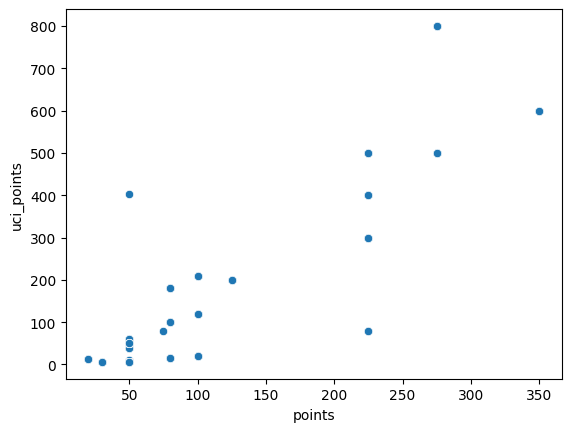

In [121]:
seaborn.scatterplot(data=races_data, x="points", y="uci_points")